# Content Analysis Project

My project is about analyzing online forum discussions related to the topic of adoptiom. To accomplish this task I gathered textual data from 2 popular subreddits with the aims of discussing adoption: r/Adoption and r/Adopted. The full and combine data set is available at this [link](https://uchicago.box.com/s/qhblnxta8j0b2nc6gexywqr81jgr9er2).

In [1]:
import pandas as pd
import numpy as np
import ast
import re
import json
import sklearn.decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix

# ! pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalMaxPooling1D, LSTM
# ! pip install tensorflow-addons
# from tensorflow_addons.layers import SparseDense ???
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm
import spacy
import gensim
from gensim.models import KeyedVectors, LdaModel

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import wordcloud 
# ! python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# data viz
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as LSC
import seaborn as sns

In [2]:
colors = ['#800000', '#D9D9D9', '#A6A6A6', '#737373']
cmap = LSC.from_list("custom_colormap", colors)

### Exploratory Data Analysis

My data comes from 3 sources in total and were combined in the above into one large data set. The first source was a reddit archival site which contained all posts from the subreddit r/Adoption until December of 2022. Furthermore I created a webscrawler and scrapper to gather more reddit posts from r/Adoption for more current posts and also to get data for r/Adopted (because the subreddit was smaller, it was not archived by the [site](https://the-eye.eu/redarcs/) I used). In total there are around 330k posts and comments in total. I keep track of a few variables: user, user flair (if any), post_title (if post, otherwise NaN), post_text, post_date, post_flair (if any), score (total of upvotes and downvotes), n_comments (if applicable), link, and subreddit. I have also created a few more columns for ease of analysis: is_comment, full_text (title + post text if applicable), cleaner_text, full_tokens, norm_tokens, token_sents, norm_sents, POS_sents, is_adoptee, num_tokens, num_norm_tokens, and sentiment. Please note that the all_df is actually created during the next section data cleaning and data wrangling but is presented here for ease of understanding the entire data set.

In [3]:
all_df = pd.read_pickle('D:\\hw\\adopt-proj\\newest_all_df.pkl')

In [4]:
# Let's take a look inside the data
all_df[100::100000]

,user,user_flair,post_date,post_flair,score,n_comments,link,is_comment,subreddit,full_text,cleaner_text,full_tokens,norm_tokens,tokens_sents,norm_sents,POS_sents,is_adoptee,num_tokens,num_norm_tokens,sentiment
100,carmitch,Transracial Adoptee,2024-01-28 09:43:18+00:00,NaN,9.0,1.0,https://old.reddit.com/r/Adopted/comments/1acz...,False,r/Adopted,Constant Frustration with my Adoptive Family. ...,constant frustration with my adoptive family. ...,"[constant, frustration, with, my, adoptive, fa...","[constant, frustration, adoptive, family, vent...","[[constant, frustration, with, my, adoptive, f...","[[constant, frustration, adoptive, family], [v...","[[(constant, JJ), (frustration, NN), (with, IN...",1,429,129,-0.4767
100100,thisismyrbnaccount,adoptee,2017-06-12 04:34:28+00:00,NaN,1.0,NaN,NaN,True,r/Adoption,The longer version has never been used. My cur...,the longer version has never been used. my cur...,"[the, longer, version, has, never, been, used,...","[long, version, current, birth, adoptive, dimi...","[[the, longer, version, has, never, been, used...","[[long, version], [current, birth, adoptive], ...","[[(the, DT), (longer, JJR), (version, NN), (ha...",1,172,56,-0.8442
200100,Englishbirdy,None,2020-10-19 21:07:30+00:00,NaN,10.0,NaN,https://old.reddit.com/r/Adoption/comments/jea...,True,r/Adoption,When your mother and your brother's adoptive p...,when your mother and your brother is adoptive ...,"[when, your, mother, and, your, brother, is, a...","[mother, brother, adoptive, parent, enter, ado...","[[when, your, mother, and, your, brother, is, ...","[[mother, brother, adoptive, parent, enter, ad...","[[(when, WRB), (your, PRP$), (mother, NN), (an...",2,258,88,0.9504
300100,sarasmileawhile,None,2022-12-15 06:11:46+00:00,NaN,22.0,NaN,https://old.reddit.com/r/Adoption/comments/zmd...,True,r/Adoption,I’m just here to say I’m sorry. That sounds in...,im just here to say im sorry. that sounds incr...,"[i, m, just, here, to, say, i, m, sorry, that,...","[m, m, sorry, sound, incredibly, painful]","[[i, m, just, here, to, say, i, m, sorry], [th...","[[m, m, sorry], [sound, incredibly, painful]]","[[(i, PRP), (m, VBP), (just, RB), (here, RB), ...",2,13,6,-0.5413


In [5]:
all_df.columns

Index(['user', 'user_flair', 'post_date', 'post_flair', 'score', 'n_comments',
       'link', 'is_comment', 'subreddit', 'full_text', 'cleaner_text',
       'full_tokens', 'norm_tokens', 'tokens_sents', 'norm_sents', 'POS_sents',
       'is_adoptee', 'num_tokens', 'num_norm_tokens', 'sentiment'],
      dtype='object')

In [6]:
all_df.shape

(302429, 20)

In [7]:
all_df.isna().sum()

user                  979
user_flair         247339
post_date               0
post_flair         297083
score                  74
n_comments         287462
link                51459
is_comment              0
subreddit               0
full_text               0
cleaner_text            0
full_tokens             0
norm_tokens             0
tokens_sents            0
norm_sents              0
POS_sents               0
is_adoptee              0
num_tokens              0
num_norm_tokens         0
sentiment               0
dtype: int64

We see that the variables are mostly textual in nature

Let's take a look at all of the variables within this data set. 

In [8]:
all_df.dtypes

user                            object
user_flair                      object
post_date          datetime64[ns, UTC]
post_flair                      object
score                          float64
n_comments                     float64
link                            object
is_comment                        bool
subreddit                       object
full_text                       object
cleaner_text                    object
full_tokens                     object
norm_tokens                     object
tokens_sents                    object
norm_sents                      object
POS_sents                       object
is_adoptee                       int64
num_tokens                       int64
num_norm_tokens                  int64
sentiment                      float64
dtype: object

We notice that most of the columns are objects (usually strings or list of strings of some sort). Only a few are numeric (word_count, n_comments, and is_adoptee). We can see in the data cleaning section below that the is_adoptee column has values of 0, 1, and 2 (which was coded by hand).

In [6]:
all_df.user_flair.value_counts()

user_flair
Adoptee                                           10344
Adoptive Parent                                    3286
adoptee                                            2925
Domestic Infant Adoptee                            2534
TRA/ICA                                            2296
                                                  ...  
Sister adopted in x2, aunt adopted out x1             1
Teen Adoptee, open adoption                           1
Adoptee &amp; Adopter                                 1
Adopting!                                             1
domestic adoptee at birth | found birthparents        1
Name: count, Length: 470, dtype: int64

I will be using the user_flairs as an approximation of ground truth values. I have hand selected the codes which I believe are related to being an adoptee and non adoptee below (notice there is some error because some posters are both identities). I will note all adoptees as 1, non adoptees as 0, and not enough information as 2.

In [10]:
adoptee_labels = ['Adoptee (UK)', 
 ' Adoptee of Closed Adoption',
 'Domestic Infant Adoptee',
 'Transracial Adoptee',
 'Adoptee',
 'International Adoptee',
 'Baby Scoop Era Adoptee',
 'Adult Adoptee (DIA)',
 'Mentally ill adopted teen',
 'adopted at birth',
 'Failed Adoptee',
 'Reunited Adoptee',
 'Adoptee ❤️',
 'Adopted at 2 from Ukraine to the USA',
 'Teen Adoptee, open adoption',
 'Adoptee and Birth Parent',
 'in adoption limbo ...',
 'adopted family divorcee, adopted by birth mom',
 'adoptee in reunion',
 'adoptee',
 'Korean-American  Adoptee',
 'Adoptee with 6 parents',
 'Happily reunited adoptee',
 '32/M/adoptee/in-reunion',
 'Adopted @ 6yo',
 '(Adoptee, 1973)',
 'Adoptee, looking',
 'Adoptee/Step Dad',
 'Adoptee and Birthmother',
 'Adoptee recently reunited',
 'Adopted',
 'Adoptee Moderator',
 'Adopted, trad/closed, Ohio',
 'Adoptee, Foster Mama',
 'Adult Adoptee',
 'Closed At-Birth Adoptee',
 'Foster Adoptee',
 'Reunited adoptee',
 'adoptee, closed adoption, seeking reunification',
 'Chinese Adoptee',
 'late-discovery-adoptee',
 'Korean Adoptee, Married, CF',
 'Adopted at birth',
 'Russian - Kiwi Adoptee',
 'Not Quite Adopted',
 'adopted',
 'INFP: The Dreamer',
 'Transracial adoptee',
 'Closed Adoption Adoptee',
 'Adoptee Recently Reuinited',
 'transracial &amp; transnational adoptee',
 'Transracial US Domestic Adult Adoptee',
 'Korean Adoptee',
 'LDA, FFY, Indigenous adoptee',
 'Adoptee',
 'Chinese Adoptee in Canada (23F)',
 '1970 Closed Adoption Adoptee',
 'adopted from China at 12mo',
 'Open Adoption Adoptee',
 'LDA, FFY, Indigenous adoptee',
 'Russian Adoptee',
 'International adoptive mom of two (Vietnam)',
 'Russian adoptee',
 'neo city 💚',
 'Pre-Adoptive / Prospective Parents (PAP)',
 'Teen Adoptee',
 'Live, Love, Learn',
 'transracial adoptee',
 'adoptee // 23',
 'TRA/ICA/KAD (minor)',
 'Adult Adoptee🤍',
 'Adult adoptee, hoping to adopt',
 'Punjabi-Canto transracial adoptee',
 'Asian Adoptee',
 'adoptee',
 'Adoptee From USA',
 'recently found my bio fam :)',
 'non paternal event / LDA',
 'Adopted',
 'Late Disclosure Adoptee, Future Adoptive Parent',
 'Private Infant Adoptee - 24F',
 'adopted at infancy',
 '(Lifelong Open) Adoptee',
 'Adoptee (🇨🇳 —&gt; 🇫🇷)',
 'Late Discovery Adoptee (LDA)',
 'International Asian TRA',
 "int'l adoptee",
 'TRA',
 'Teen Adoptee, open adoption',
 'Adoptee &amp; Genealogical Detective!',
 'adult adoptee',
 'multiracial // transracial adoptee | prioritizing adoptee voices',
 'step adoptee',
 'half-adopted, hap',
 'Adoptee @ 106 Days &amp; Genealogical Detective!',
 'Adoptee; Confused as Hell',
 'Second-generation adoptee',
 'TRA/ICA',
 'Adoptee (domestic infant adoption)',
 'Closed Adoption Infant Adoptee',
 'UK Adoptee',
 'Closed domestic (US) infant adoptee in reunion',
 'adopted & hap',
 'Adopted in the late 60’s',
 'Transracial Adult Adoptee',
 'Adoptee @ 106 Days & Genealogical Detective',
 'Adoptee & AP',
 'adoptee & parent',
 'Domestic Infant Adoptee',
 '🇷🇺',
 'Closed domestic (US) adult adoptee in reunion',
 'Black adult invisible adoptee',
 'Chinese American Adoptee',
 'Adoptee (US)',
 '60s scoop reunited',
 'transracial adoptee',
 'DIA in Reunion',
 'Adoptee of Closed Adoption',
 'Private Infant Adoptee - 25F',
 'transracial closed adoptee',
 "adoptee '87",
 'TRA / Chinese adoptee',
 'Late discovery adoptee, 26 yrs. Met bio families.',
 'Adult DIA Adoptee',
 'late age adoptee',
 'adoptee & birthparent',
 'victim of domestic & state violence via transracial adoption',
 'Adoptee, Birthmother, & Parent',
 'Domestic Adoptee 1988',
 'BIA adoptee',
 'foster care (2007-2010) / adopted (2010)',
 'adoptee open adoption',
 'Adoptee and Psychologist',
 'Who am I?',
 'domestic infant(ish) adoptee',
 'Adoptee of Failed Adoption',
 'Adoptee and  Birthmother',
 'adoptee + adoptive parent',
 'Reunited Adoptee &amp; Adoptee Rights Activist',
 'Adoptee, Adoptive Parent',
 'adoptee 3.11.87',
 'Adopted Faery',
 'Child of two families'
 'Adopted Kid',
 'Adopted from Bangladesh',
 'KAD wutup!',
 'Adopted: birth.  Found bio siblings: age 20.',
 'Adoptee, 29F',
 'Closed adoption: birth. Found bio siblings: age 20.',
 'Adoptee /  Adoptive Parent',
 'Adoptee Found Birth Family',
 'adoptee; foster parent',
 'Adopted/Plans to adopt',
 'Transracial Adoptee (KAD)',
 'Birthmom+Adoptee',
 'Adopted at Birth | Found Birthfamily',
 'Foster Parent/Adoptee',
 'Moderator, adoptee',
 'Two moms, two dads, lucky reunited adoptee',
 'adoptee / plans to adopt',
 'Adopted 1993 | Reunited 2017',
 'Adopted as a baby',
 'Chinese adoptee',
 'Adoptee (International)',
 'Adoptee, Birthmother, Adoptive parent',
 'Adoptee, Activist',
 'Adopted from Russia',
 'Adoptee - Found birth family',
 'Punjabi-Canto interracial adoptee',
 'Korean adoptee',
 'Transracial Adoptee &amp; Birth Mother',
 'Trans-Racial Adoptee | PAP | Anti-Natalist',
 'Kazakh adoptee',
 'late-discovery adoptee, ex-ward',
 'LDA, ex-ward, Indigenous post-ICWA adoptee',
 'Adult Adoptee/Found Bio Parents - Ohio 1986 Prive Adoption',
 'Transnational Adoptee from Birth',
 "author, the adoptee's guide to dna testing (book)",
 'LDA, ex-ward, Indigenous adoptee',
 'Adoptee, Only Child',
 'Closed Adoption Adoptee Reunited',
 'late-discovery-adoptee, ex-foster-kid',
 'Adoptee &amp; Adopter',
 'Taiwanese Adoptee',
 'r/Adoptee Moderator',
 'Closed DIA',
 'Adopted aged four',
 'Adult adoptee',
 'Adopted @11days - reunited @ 27y/o',
 'TRA/IA/LDA/AP/FP',
 'intrafamily adoptee, school aged adoptee',
 'Adoptee/closed Birthmom/open',
 'china adoptee',
 'Childhood adoptee/Birthmother to now adult',
 'First Nations Adoptee',
 'Chinese Transracial Adoptee',
 'second-generation adoptee',
 'International adoptee',
 'International Transracial Adoptee',
 'From Russia with Love?',
 'FFY/Adoptee',
 'TransAdoptedKid',
 'adoptee and 23 ✌️',
 'Adopted Person',
 'adoptee/former foster kid',
 'Pre-Adoptive Parent | Adopted',
 'adoptee // 24',
 'victim of domestic &amp; state violence via transracial adoption',
 'cambodian adoptee',
 'Adult Adoptee Found BioFamily',
 'Birth adoptee reunited w/BM &amp; Half-Siblings',
 'Adoptee, may consider adoption in the future',
 'Adopted from China',
 'Adopted at birth',
 'Transracial Indigenous Adoptee',
 'Adoptee from birth',
 'Adopted Chinese',
 'reunited adoptee',
 'TRA/ICA/KAD',
 'Adopted as an Infant',
 'Transracial/international Adoptee',
 'open adoptee from birth',
 'Half-adopted',
 'adoptee &amp; parent',
 'Adopted at Birth',
 'domestic adoptee at birth | found birthparents']

# for regex will need to add \\ to escape the escape characters
adoptee_labels = [re.escape(i) for i in adoptee_labels]
# | to signify "or" for future regex
adoptee_pattern = re.compile(r"{}".format("|".join(adoptee_labels)), 
                             re.IGNORECASE)

# Now do the same for non adoptee labels
non_adoptee_labels = ['Former Foster Youth',
 'Future AP',
 'Bio Parent',
 'Birthfather',
 'Prospective Adoptive Parent',
 'Birth Mother - Open Adoption',
 'Mom through private domestic open transracial adoption',
 'Reunited mother, former legal guardian, NPE',
 'Reunited Mom, Foster Mom, L8 Dscvry Adoptee-paternal side',
 'Reunited Birthparent.',
 'Current Intl AP, Past Temp Foster Child',
 'Birth Mom',
 'AP, former FP, ASis',
 'Birthmother.',
 'birthmother',
 'Birthmother 6/23/12',
 '14 adoptions in my family',
 'Hopeful AP',
 'Adoptive parent',
 'birth parent',
 'Adoptive Parent',
 'Birthmother, 2002',
 'Biological Father - searching',
 'looking to adopt',
 'adoptive father',
 'Father of sibling group of 3',
 'birth mom',
 'Hopeful adopter',
 'Adopting in Arkansas',
 'Birthmom',
 'Hoping to adopt',
 'Looking into Adopting',
 'caseyalexanderblog.wordpress.com',
 'naturalmother_8-14-01',
 'Someday-adopter',
 'Potential Birthmother',
 'waiting prospective AP',
 'future AP',
 'foster-to-adopt aunt/mom',
 'Adoptive Dad',
 'BP',
 'I Fostered &amp; Then Adopted',
 'Adoptive Parent/Orphanage Supervisor',
 'Adoptive Parent (fostadopt)',
 'hypervigilant.org',
 'Possible AP',
 'fost-adopt parent',
 'pre-adoptive parent',
 'Birth Parent',
 'Birth Father &amp; /r/OpenAdoption Owner',
 'RecentBM',
 'Birthmother',
 'Adoptive/Foster Mom',
 'Adoptive Father',
 'foster adopt',
 'Adopted Family Member?',
 'Prospective adoptive parent',
 'Pre-fostering | prospective foster',
 'First Mother',
 'Bio of 2, Adoptive of 2',
 'Sister adopted in x2, aunt adopted out x1',
 'Hopeful APs',
 'Researching foster/adoptive parenting',
 'future FAD parent',
 'Birthmother, Open Adoption',
 'Adopting!',
 'Adoptive Parent - Intercountry + Fostered',
 'Post-Adoptions social worker', 
 'Adoptive Parent, Data Analyst',
 'Bio sis',
 'Adoptive/Foster Parent',
 'ex-foster-kid',
 'kinship adoptive parent / foster parent',
 'Birthmother 2/13/2002',
 'Transracial Adoptive Parent/Foster Parent',
 'parent of adopted kids',
 'Adoptive Mama',
 'AP',
 'Birthfather 10/21/1986',
 'Interested, but no plans',
 'Planning to Adopt in the Future',
 'Future Foster/Adoptive Parent',
 'Birth mother',
 'Foster parent/Adoptive parent',
 'Firstmom',
 'Son, 12.. BirthMom',
 'Father of 3, all adopted',
 'kinship/foster parent',
 'Momma',
 '23F- Future Adopter',
 'Reunited Mom',
 'Foster parent',
 'Adoptive father',
 'firstmother 2001',
 'Adoptive mom of 3',
 'Adoptive Dad of 3, soon 6',
 'bio sibling',
 '5 failed matches, currently in #6 due winter 2016',
 'Soon to be mom',
 'Potential Adoptive Parent',
 'foster/pre-adoptive parent',
 'Intl Adoptive Parent',
 'In Progress',
 'Wanting to Adopt',
 'Birth Father',
 '2 failed matches, still hoping',
 'adoptive mom',
 '3 failed matches, still hoping',
 'Someday-adopter, adoptive sister',
 'Future adoptive parent',
 'Matched with an expectant mom due in winter 2015',
 'Adoptive Parents',
 'Birthmother (Open Adoption)',
 'AParent to teen',
 'Son, 8.. BirthMom',
 'Future Parent',
 'considering adopting',
 'Looking to adopt (Ontario)',
 'Homestudied and waiting',
 'Adopting thru Foster Care',
 'sister of adoptee; future adoptive parent',
 'Adoptive sister',
 'Adoptive Dad of 3, soon 5',
 'Adoption Researcher',
 'was a foster parent',
 'Parent',
 'hoping to adopt',
 'Father of 4 adopted sons',
 'birthmom 2010, beautiful boy!',
 'would like to adopt',
 'Foster-to-Adopt',
 'Birthmom 7/31/1992',
 'potential adoptive father',
 '-25-groomer-wannabe adopter',
 'Luckiest',
 'Homestudied hopeful adopter',
 '3 adopted',
 'sister of an adoptee',
 'parent of several adopted kids',
 'Birthmother, Daughter, Sister, Aunt, and Wife',
 'adoptDad',
 '(b-mom, 1976)',
 'Birthmom 3/15/98',
 'Adoption Specialist',
 'Fost-Adoptive parent of 3',
 'HAP',
 'Adoptive mom - open kinship',
 'sister of adoptee; hopeful future AP',
 'Birth Mom',
 'haole, male, father to a daughter who was adopted, but not by me',
 'may adopt in the future',
 'LGBT adoptive parent &amp; daughter of adoptee',
 'Adoptive Parent of Older Teen',
 'prospective/pre-adoptive parent',
 'Birthmom 2017',
 'Birthmom 12/18/18',
 'Furture adoptive mom, by choice.',
 'Adoptive Parent x3',
 'Future Father',
 'Adoptive Parent &amp; Spouse to Adoptee',
 'Adoptive Mama',
 'prospective adoptive parent',
 'Bio-Sis, Hopefully Future Adoptive Parent',
 'Kinship AP',
 'NY, Adoptive Parent, Permanency Specialist',
 'Prospective AP',
 'FFY - AP',
 'Perspective adoptive parent',
 'Adoptive Parent (International/Transracial)',
 'Birth Mum.',
 'Former foster kid. Almost-adopted more than once.',
 'Adoptive Mother | Australia',
 'Hoping to Adopt',
 'Parent by Adoption',
 'Researching PAP',
 'One Adopted (Kinship), Seven Bio',
 'Adoptive Parent (Kinship Via Husband)',
 'foster mom',
 'Younger Bio Sibling',
 'Foster/Adoptive parent',
 'AdoptiveParent',
 'Adult Child of Adoptee',
 'AP of teen',
 'adoptive parent',
 'Birth mom, 2017',
 'Birth Mum of two - adopted by force.',
 'buried under a pile of children',
 'Adoptive mom',
 'Daughter of 2 adoptees',
 'Adoptive Mother',
 'Reunited Birthparent.',
 'Foster Parent',
 'Adoptive Dad of 5 (2 sib grps from foster care)',
 'Birthmother 12/13/2002',
 'PAP',
 'Prospective Parent',
 'AP, former FP, ASis',
 'biological parent',
 'Birth Parent in StepParent Adoption',
 'Open Adoption Birth Father &amp; /r/OpenAdoption Owner',
 'Foster Parent, Child Welfare Public Health Professional',
 'Have adopted-in siblings; searching for adopted-out sister',
 'Pre-Placement Parent',
 '16|05.20.2020|Adoption',
 'Prep-Adoptive',
 'daughter of an adoptee',
 'Adoptive Mom',
 'reunited mom, lgl grdian, NPE',
 'Birth Mother',
 'NPE',
 'Bio-Sib of an adoptee',
 'Potential Foster Parent',
 'Foster / Adoptive Parent',
 'Foster Mom',
 'mother was adopted',
 'Stepmum to long lost adoptee / reunited',
 'daughter of an adoptee. future adoptive parent.',
 'Birthparent / Baby Girl due 12/28 :)',
 'Prospective Adoptive Mother',
 'Reunited Birthmom',
 'Foster/Adoptive Parent',
 'Hopeful Adoptive Parent',
 'foster parent',
 'Prospective Adoptive Parent',
 'hopeful foster parent',
 '15 adoptions in my family',
 'Reunited Birthparent.',
 'Reunited Bio Mom',
 'Adoptive Parent &amp; Adoptee’s spouse']

non_adoptee_labels = [re.escape(i) for i in non_adoptee_labels]
non_adoptee_pattern = re.compile(r"{}".format("|".join(non_adoptee_labels)), 
                                 re.IGNORECASE)

#### Helpers

These helper functions help me load in the appropriate data and also clean the individual posts

In [9]:
# for opening reddit json
def open_reddit_json(file_path):
    """
    Takes a string of a json (of scrapped Reddit data) file and turns it into a dataframe
    Inputs:
        file_path (str): the file path of the JSON file
    Returns pandas DataFrame of pertinent information
    """
    file = open(file_path, "r")

    users = []
    user_flairs = []
    titles = []
    post_texts = []
    post_dates = []
    post_flairs = []
    scores = []
    n_comments_list = []
    links = []

    for line in file:
        post = json.loads(line)

        try:
            users.append(post.get("author", np.nan))
            user_flairs.append(post.get("author_flair_text", np.nan))
            titles.append(post.get("title", np.nan)) # will be nan for comments

            # post text data is located in different places if comment vs post
            post_text = post.get("selftext")
            if post_text:
                post_texts.append(post_text)
            else:
                post_texts.append(post.get("body", np.nan))

            post_dates.append(post.get("created_utc", np.nan))
            post_flairs.append(post.get("link_flair_text", np.nan))
            scores.append(post.get("score", np.nan))
            n_comments_list.append(post.get("num_comments", np.nan))
            if post.get("permalink"):
                links.append("https://old.reddit.com" + post.get("permalink", np.nan))
            else:
                links.append(np.nan)       
        except:
            continue            

    output = pd.DataFrame({"user": users,
                           "user_flair": user_flairs,
                           "title": titles,
                           "post_text": post_texts,
                           "post_date": post_dates,
                           "post_flair": post_flairs,
                           "score": scores,
                           "n_comments": n_comments_list,
                           "link": links})
    return output


def categorize_user(x):
    """
    Given a user flair (str) categorize as either adoptee, non-adoptee, 
        or NEI (not enough info)
    Input: X (str): a user flair
    Returns: 1 if adoptee, 0 if non-adoptee, 2 if NEI    
    """
    if adoptee_pattern.match(x):
        return 1  # Adoptee
    elif non_adoptee_pattern.match(x):
        return 0  # Non-adoptee
    else:
        return 2  # NEI


### HELPERS INSPIRED BY HW2 AND HW4 OF CONTENT ANALYSIS ###

# NOT ACTUALLY USED
# def word_tokenize(word_list):
#     """
#     Tokenize a list of words or a single string
#     Input: list of strings or a single string
#     Returns a list of tokenized strings
#     """
#     # Pass word list through language model
#     if isinstance(word_list, str):
#         word_list = [word_list]
#     doc = nlp(" ".join(word_list))    
#     return [token.text for token in doc if not token.is_punct and token.text.strip()]


# NOT ACTUALLY USED
# def normalize_tokens(word_list):
#     """
#     Tokenize and normalize a list of words
#     Inputs:
#         word_list: list of strings for words to be tokenized
#     Returns a list of normalized strings
#     """
#     # Convert word_list to a single string
#     if isinstance(word_list, list):
#         word_list = ' '.join(word_list)
    
#     # Tokenize the text and convert to lowercase
#     doc = nlp(word_list.lower())

#     # Extract normalized tokens
#     normalized = [str(w.lemma_) for w in doc 
#                   if not w.is_stop and not w.is_punct 
#                   and not w.like_num and len(w.text.strip()) > 0]

#     return normalized


# USED, logic stems from above two functions
def tokenize_and_normalize(word_list):
    """
    combine the logic for the two functions above
    """
    if isinstance(word_list, list):
        word_list = ' '.join(word_list)
    doc = nlp(word_list.lower())
    tokenzied = [token.text for token in doc 
                 if not token.is_punct and token.text.strip()]
    normalized = [str(w.lemma_) for w in doc 
                  if not w.is_stop and not w.is_punct 
                  and not w.like_num and len(w.text.strip()) > 0]

    return tokenzied, normalized


def tokenize_sents(word_list, model=nlp):
    """
    Tokenize a list of words using a specified model.

    Parameters:
        word_list (list): A list of words to be tokenized into sentences.
        model (Spacy model): the language model to be used for tokenization. 
            Defaults to nlp model.

    Returns:
        list: list of sentences extracted from the input text.
    """
    doc = model(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences


def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)

    return pos_sents

### Data Cleaning, Merging, Wrangling

In this section I take the raw text data gathered from the scrapper and archival data and bring it all together. For starters, I reformat some of the data and add some extra information to track comments, subreddit, etc. 

In [4]:
# for r/Adopted
adopted_df = pd.read_csv("D:\\hw\\adopt-proj\\adopt_posts.csv")
# change to date time
adopted_df['post_date'] = pd.to_datetime(adopted_df['post_date'])
adopted_df['subreddit'] = "r/Adopted"

# for r/Adoption
adoption_1 = pd.read_csv("D:\\hw\\adopt-proj\\adoption_posts.csv")

adoption_2_posts = open_reddit_json("D:\\hw\\adopt-proj\\Adoption_submissions.json")
adoption_2_comms = open_reddit_json("D:\\hw\\adopt-proj\\Adoption_comments.json")
adoption_2_posts["is_comment"] = False
adoption_2_comms["is_comment"] = True

# fix post date data type
adoption_1['post_date'] = pd.to_datetime(adoption_1['post_date'])
adoption_2_comms['post_date'] = pd.to_datetime(adoption_2_comms['post_date'].astype(int), unit='s').dt.tz_localize("UTC")
adoption_2_posts['post_date'] = pd.to_datetime(adoption_2_posts['post_date'].astype(int), unit='s').dt.tz_localize("UTC")

# combine all sources of r/Adoption data
adoption_df = pd.concat([adoption_1, adoption_2_posts, adoption_2_comms])
adoption_df['subreddit'] = "r/Adoption"

Next I combine all the data into one giant dataframe. I also combine the text from the titles (if present) and the post/comment together because the titles often provide very useful summaries of a post in question. I also remove empty posts and remove posts and comments that have been removed or deleted because they do not provide useful textual information. I will also remove duplicates

In [5]:
# combine both subreddits
all_df = pd.concat([adopted_df, adoption_df])
print("The unedited dataframe is size:", all_df.shape)
# drop na
all_df.dropna(subset=['post_text'], inplace=True)
# reset indices 
all_df.reset_index(drop=True, inplace=True)
all_df["full_text"] = (all_df.title.fillna("") +  ". " + 
                       all_df.post_text).replace(r"^. ", "", regex=True)

The unedited dataframe is size: (332300, 11)


In [6]:
# remove rows with nans or empty strings
all_df = all_df[all_df.dropna(subset=['full_text']).full_text != ""]
# for some reason there is this one weird character for score in one row
all_df.replace("•", np.nan, inplace=True)
all_df["score"] = all_df.score.astype(float)

In [7]:
useless_posts = r"^(?:\(|\[)?(?:deleted|removed)(?:\)|\])?[\s-]*"
# filter out the useless posts
all_df = all_df[~all_df['post_text'].str.contains(useless_posts, case=False, regex=True)]

In [8]:
# remove duplicates
all_df.drop_duplicates(subset=["user","title", "subreddit", "post_text", "full_text"], inplace=True)

In [10]:
# because the info is stored in full_text, we don't need these columns anymore
all_df.drop(columns=["title", "post_text"], inplace=True)
all_df.reset_index(drop=True, inplace=True)

#### Let's add some sentiment weighting to the text. This comes from the 

VADER does extremely well at social media posts like these, according to this [study](https://ojs.aaai.org/index.php/ICWSM/article/download/14550/14399/18068).

In [ ]:
tqdm().pandas()
all_df["sentiment"] = all_df.norm_tokens.progress_apply(lambda x:
    " ".join(x)).progress_apply(lambda x:
    SentimentIntensityAnalyzer().polarity_scores(x)["compound"])
all_df.to_pickle("/content/drive/MyDrive/Colab Notebooks/UPDATED_all_df.pkl")

In [54]:
sentiment = pd.read_pickle("D:\\hw\\adopt-proj\\sentiments.pkl")
all_df["sentiment"] = sentiment

In [11]:
all_df.sentiment.describe()

count    302429.000000
mean          0.387639
std           0.555170
min          -0.999500
25%           0.000000
50%           0.557400
75%           0.868900
max           0.999800
Name: sentiment, dtype: float64

We see that these posts cover a range of positive and negative sentiments. Furthermore we see that the mean is positive but skewed negative (mean < meadian). Let's break it down by subreddit

In [12]:
all_df[all_df.subreddit == "r/Adoption"].sentiment.describe()

count    285268.000000
mean          0.395986
std           0.551320
min          -0.999500
25%           0.000000
50%           0.571900
75%           0.872000
max           0.999800
Name: sentiment, dtype: float64

In [13]:
all_df[all_df.subreddit == "r/Adopted"].sentiment.describe()

count    17161.000000
mean         0.248874
std          0.598860
min         -0.998700
25%         -0.177900
50%          0.381800
75%          0.790600
max          0.999100
Name: sentiment, dtype: float64

No we can see that the average sentiment for posts from r/Adopted are more neutral and less positive than on r/Adoption

#### Finally, we make the column for categorization: adoptees and non adoptees

In [51]:
# let's add labels and non labels
all_df["is_adoptee"] = all_df["user_flair"].astype(str).apply(categorize_user)

#### Now that we have filtered out rows will not be using in the analysis, it is time to move onto further data cleaning and wrangling

In [ ]:
nonenglish_syms = r"""[^a-zA-Z\d \.\?\,\!\-\#\:\:\\\\\/]"""
straight_curly = r"[\’\‘\“\”]"
# filter created with help from ChatGPT
url_pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"

In [ ]:
# stop word stuff
# set a stopwords set
stop_words = set(stopwords.words('english'))
# add more stop words
custom_stopwords = set(["could've", "would've", "r", "u/", "u", "/r" "r/", "t", 've', 's', 'm', 
                        'll', 'd', 're', 'n', 'y', 'b', 'p', 'f', 'c', 'e', 'g', 
                        'h', 'j', 'k', 'l', 'o', 'q', 'v', 'w', 'x', 'z', 'a', 'i', "gt", "amp"])

stop_words.update(custom_stopwords)
remove_stops = r'\b(?:{})\b'.format('|'.join(stop_words))
# update nlp stopwords vocab
for stopword in stop_words:
    nlp.vocab[stopword].is_stop = True


Clean the the text

In [ ]:
all_df["cleaner_text"] = all_df.full_text.str.lower().replace(url_pattern, " ",
                                        regex=True).replace(nonenglish_syms, " ", 
                                        regex=True)

Process the text (tokenize, normalize, POS tagging) for words and sentences

In [ ]:
# for progress_apply bars
tqdm.pandas()

In [ ]:
all_df["full_tokens"], all_df["norm_tokens"] = zip(*all_df.cleaner_text.progress_apply(lambda x: tokenize_and_normalize(x)))

100%|██████████| 302429/302429 [1:08:24<00:00, 73.69it/s] 


In [ ]:
all_df["toke_sents"], all_df["norm_sents"] = zip(*all_df.cleaner_text.progress_apply(lambda x: zip(*[tokenize_and_normalize(s) for s in tokenize_sents(x)])))

100%|██████████| 302429/302429 [3:44:27<00:00, 22.46it/s]    


In [ ]:
all_df['POS_sents'] = all_df.toke_sents.progress_apply(lambda x: tag_sents_pos(x))

100%|██████████| 302429/302429 [1:05:45<00:00, 76.64it/s] 


In [ ]:
# add counts
all_df["num_tokens"] = all_df.full_tokens.apply(len)
all_df["num_norm_tokens"] = all_df.norm_tokens.apply(len)

In [60]:
all_df.to_pickle("newest_all_df.pkl")

# Some Minor data viz

In [1]:
# Helpers

def plot_freqs(data, n=50, freq=True, title='    Word Frequency\n'):
    """
    Plot two bar plots side by side.
    Inputs:
        data (dict of pd.Series or FreqDist): Maps a str regarding the source of data 
            to a pandas series or FreqDist containing the strs for the corresponding words
        n (int): Number of words (default=50).
        freq (bool): Whether to plot the frequency or the count (default=True).
        title (str): Title for the entire figure 
            (default='    Normalized Token Frequency\n').

    Return None, plots word counts/frequency charts side by side
    """
    # figure out the dimensions of the subplots
    fig, axs = plt.subplots(2, 1, figsize=(n**.5 * 16 / 10, 9))

    # create a title for the entire plot
    fig.suptitle(title, fontsize=24, ha='center') # title for entire plot

    # plot every source and word column 
    for i, (source, structure) in enumerate(data.items()):
        
        # check if the structure is a pandas series
        if type(structure) == pd.core.series.Series:
            freqs = FreqDist(structure.explode())
        # get the top most common words
            top_n = pd.DataFrame(freqs.most_common(n), 
                                 columns=["word", "freq"])
        # check if FreqDist
        elif type(structure) == nltk.probability.FreqDist:
            top_n = pd.DataFrame(structure.most_common(n), 
                                 columns=["word", "freq"])
        # if the word_col is not a pandas series or nltk FreqDist, raise an error
        else:
            raise ValueError("word_col must be a pandas series or a nltk FreqDist")

        # if freq is true, plot the frequency, otherwise plot the count
        if freq: # Calculate total count
            total_count = top_n['freq'].sum()
            # Calculate percents
            top_n['percent'] = (top_n['freq'] / total_count) * 100
            # plot the the top n words
            y_data = top_n.percent
            y_label = 'Frequency (%)'
        else:
            y_data = top_n.freq
            y_label = "Counts"

        axs[i].plot(top_n.word, y_data, color='#800000', marker="o")

        # labeling axes and ticks
        axs[i].set_ylabel(y_label, fontsize=16)
        # set x ticks
        axs[i].set_xticks(top_n.word)
        axs[i].set_xticklabels(top_n.word, rotation=45, ha='right', fontsize=12)
        axs[i].set_xlabel(source, fontsize=16, ha='center')
        axs[i].xaxis.set_label_position('top')
    # plot side by side
    plt.tight_layout()
    plt.show()
    return


def plot_comp_bars(sources, n=50):
    """
    Plot a bar chart comparing shared words from the top n words from 2 sources
    Inputs:
        sources (dict of FreqDist): Maps a str regarding the source of data 
            to FreqDist of the word counts for the corresponding words
        n (int): Number of words (default=50).
        title (str): Title for the plot (default='').

    Return a DF with frequencies (%) for each word matching both sources, 
        plots word counts/frequency bar chart comparing sources
    """
    values = list(sources.values())
    keys = list(sources.keys())
    if type(values[0]) == nltk.probability.FreqDist:
        word_freq_1 = values[0]
    elif type(values[0]) == pd.core.series.Series:
        word_freq_1 = FreqDist(values[0].explode())        
    else:
        raise ValueError("word_col must be a nltk FreqDist")

    if type(values[1]) == nltk.probability.FreqDist:
        word_freq_2 = values[1]
    elif type(values[1]) == pd.core.series.Series:
        word_freq_2 = FreqDist(values[1].explode())        
    else:
        raise ValueError("Data in source Dict must be an nltk FreqDist or a pandas Series")

    max_iters = min(len(word_freq_1), len(word_freq_2))
    if n > max_iters:
        warning = f"n = {n} is greater than the length of the FreqDist ({max_iters}), setting n to {max_iters} instead"
        warnings.warn(warning)
        n = max_iters
    i = n
    # iterate until we reach n matches or stop at smaller of the FreqDist lengths
    while True:
        
        # Get the top most common words
        top_n_1 = pd.DataFrame(word_freq_1.most_common(i), 
                               columns=["word","freq"])
        top_n_2 = pd.DataFrame(word_freq_2.most_common(i), 
                               columns=["word","freq"])
        
        # because we are comparing distr, we should get percentages
        top_n_1["percent"] = (top_n_1['freq'] / top_n_1['freq'].sum()) * 100
        top_n_2["percent"] = (top_n_2['freq'] / top_n_2['freq'].sum()) * 100

        # Merge the social media and news counts into one df and get the percentages
        all_top_n = pd.merge(top_n_1.groupby('word').sum(), 
                            top_n_2.groupby('word').sum(), 
                            on='word').drop(columns=['freq_x', 'freq_y'], 
                                            axis=1).reset_index()
        # if we fail to reach n matches, we should increment i
        len_all_top_n = len(all_top_n)
        if len_all_top_n < n and i <= max_iters:
            i += 1
        else:
            # should remind user if did not reach n matches
            if len_all_top_n < n:
                warning = f"Did not reach {n} matches, plotted all {len(all_top_n)} possible matches"
                n = len(all_top_n)
                warnings.warn(warning)
            
            # rename columns to be more informative
            all_top_n = all_top_n.rename(columns={'percent_x': f'{keys[0]}',
                                                  "percent_y": f'{keys[1]}'})
            
            # sort the values by the first source
            all_top_n_sorted = all_top_n.sort_values(by=f'{keys[0]}', 
                                                     ascending=False)
            # plot the bar graph
            ax = all_top_n_sorted.plot(kind='bar', x='word',
                                       # set the figsize based off of n sorta :)
                                       figsize=(n**.5 * 16 / 5, 9), 
                                       color=colors[0::3],
                                       width=.75)
            # set labels
            ax.set_title(f"Top {n} Words in {keys[0]} and {keys[1]}", fontsize=18)
            ax.set_xticklabels(all_top_n_sorted.word, rotation=45, ha='right', 
                               fontsize=12)
            ax.set_xlabel("")
            ax.set_ylabel('Frequency (%)', fontsize=14)
            plt.show()
            return all_top_n_sorted
        

def make_word_cloud(data, max_words=100, title=""):
    """
    Create a WordCloud object with specified parameters and plot it
    Inputs:
        data: (str) a string of data to be used for the word cloud
        max_words: (int) maximum number of words to display (default=100)
        title: (str) title for the plot (default="")
    Returns None, plots a word cloud
    """
    wc = wordcloud.WordCloud(background_color="white", max_words=max_words, 
                             width=1000, colormap=cmap,height=1000, 
                             mode='RGBA', scale=.5)
    
    if type(data) == pd.core.series.Series:
        wc = wc.generate(" ".join(data))
    elif type(data) == nltk.probability.FreqDist:
        wc = wc.generate_from_frequencies(data)
    else:
        raise ValueError("Data must be an pandas Series or a nltk FreqDist")
    plt.figure(figsize=(6, 6))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title)
    plt.show()
    return

In [3]:
adoptee_words = all_df[all_df.is_adoptee == 1].norm_tokens.explode().dropna(
    ).reset_index(drop=True)
non_adoptee_words = all_df[all_df.is_adoptee == 0].norm_tokens.explode().dropna(
    ).reset_index(drop=True)

r_adopted_words = all_df[all_df.subreddit == "r/Adopted"].norm_tokens.explode(
    ).dropna().reset_index(drop=True)
r_adoption_words = all_df[all_df.subreddit == "r/Adoption"].norm_tokens.explode(
    ).dropna().reset_index(drop=True)

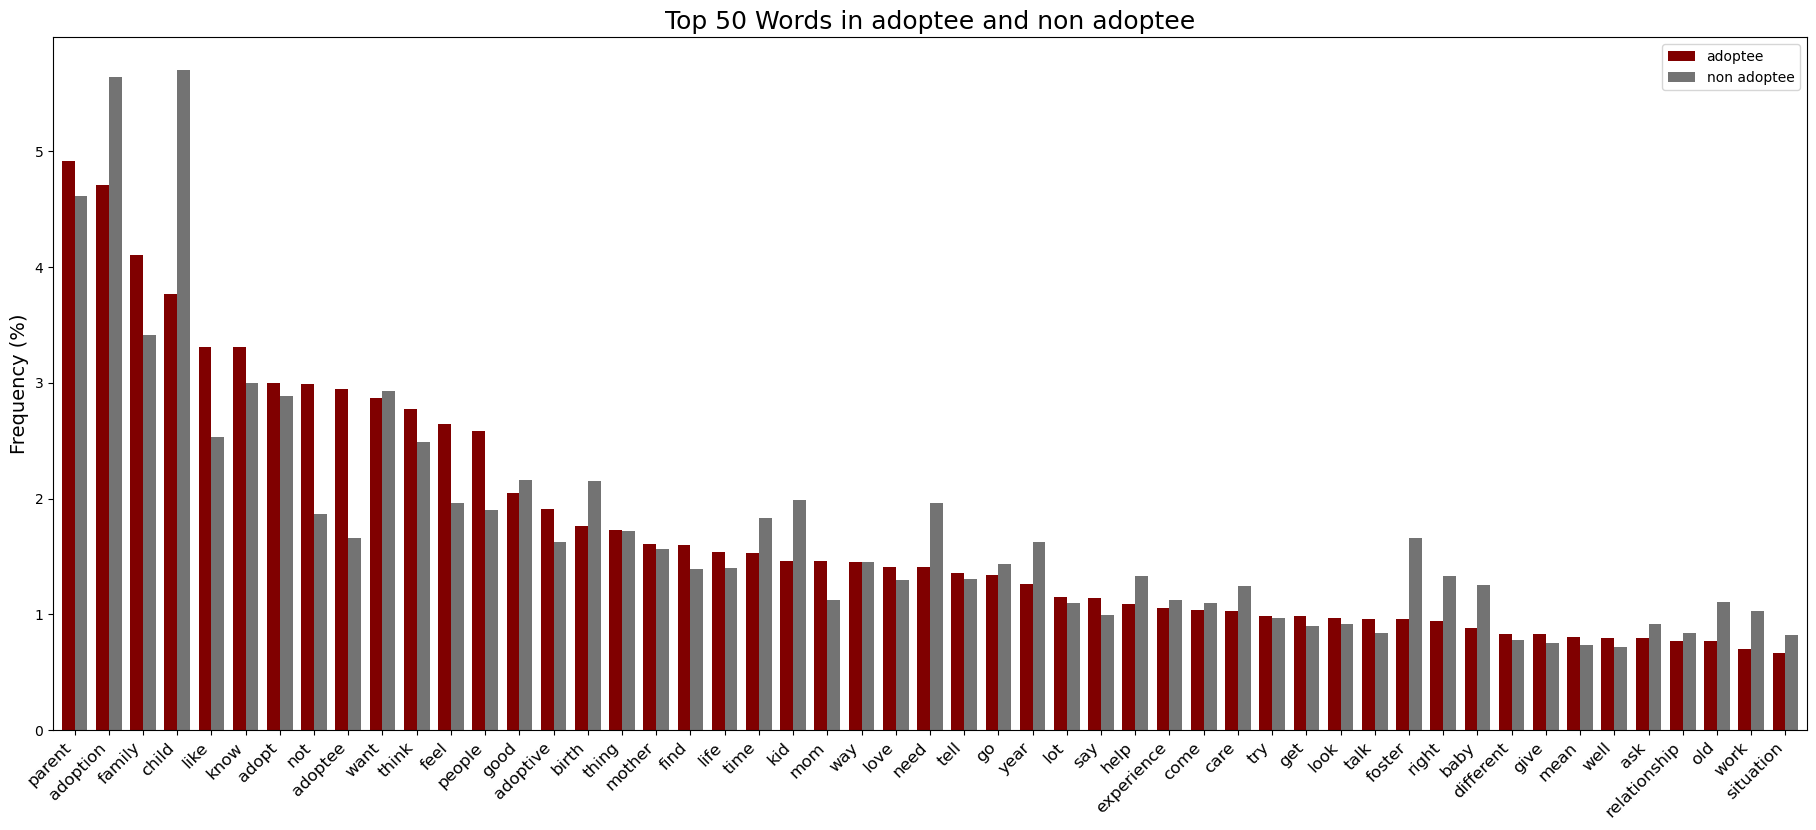

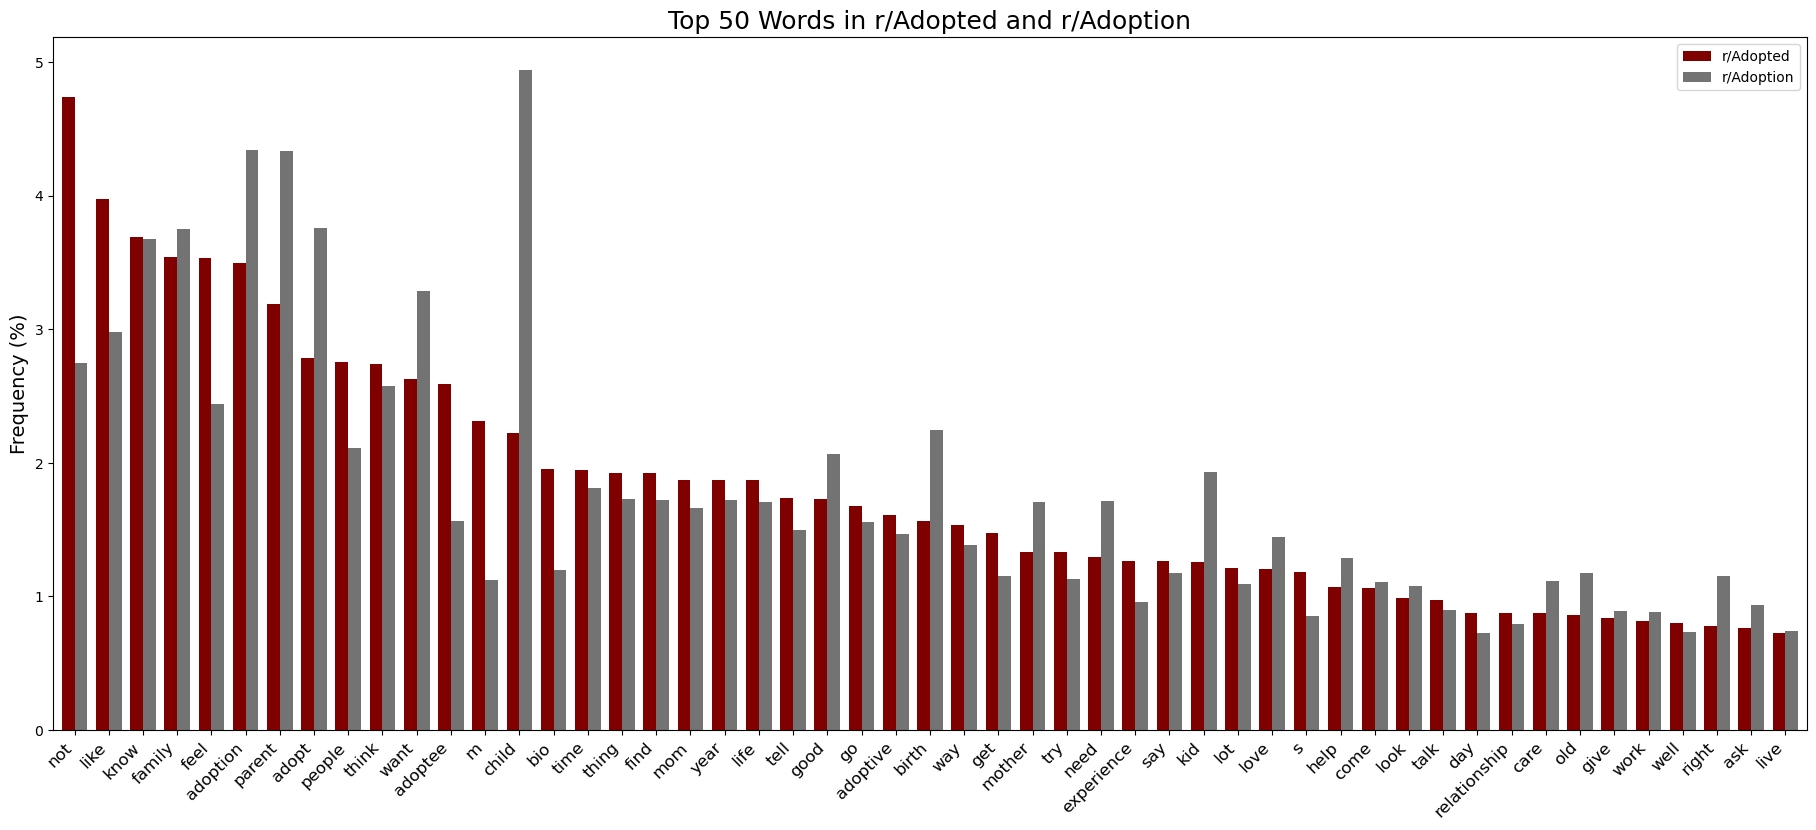

In [ ]:
a_na_freqs = plot_comp_bars({"adoptee": adoptee_words, "non adoptee": non_adoptee_words}, n=50)
subs_freqs = plot_comp_bars({"r/Adopted": r_adopted_words, "r/Adoption": r_adoption_words}, n=50)

In [ ]:
r_adopted_POS = pd.Series(all_df[all_df.subreddit == "r/Adopted"].POS_sents.explode(
    ).explode().dropna()).reset_index(drop=True)
r_adopted_POS_non = r_adopted_POS[~r_adopted_POS.apply(lambda x: x[0] in stop_words)]
r_adopted_cfdist_POS = nltk.ConditionalFreqDist((p, w) for w, p in r_adopted_POS_non)

r_adoption_POS = pd.Series(all_df[all_df.subreddit == "r/Adoption"].POS_sents.explode(
    ).explode().dropna()).reset_index(drop=True)
r_adoption_POS_non = r_adoption_POS[~r_adoption_POS.apply(lambda x: x[0] in stop_words)]
r_adoption_cfdist_POS = nltk.ConditionalFreqDist((p, w) for w, p in r_adoption_POS_non)

In [ ]:
make_word_cloud(non_adoptee_words, max_words=100)

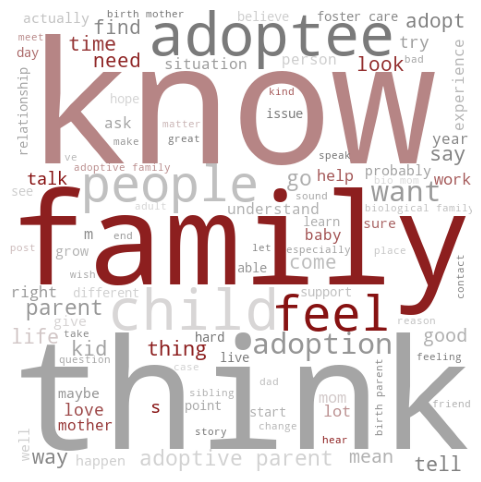

In [ ]:
make_word_cloud(adoptee_words, max_words=100)

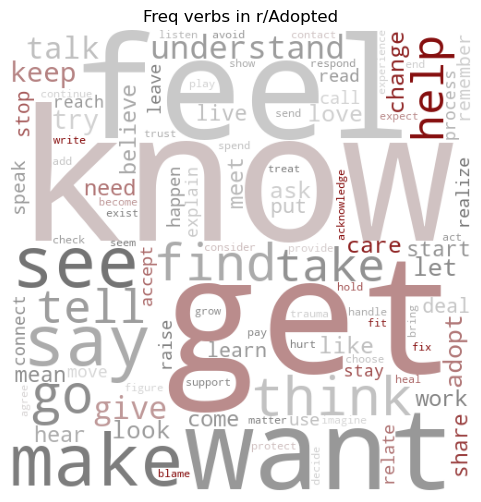

In [ ]:
make_word_cloud(r_adopted_cfdist_POS["VB"], max_words=100, 
                title="Freq verbs in r/Adopted")

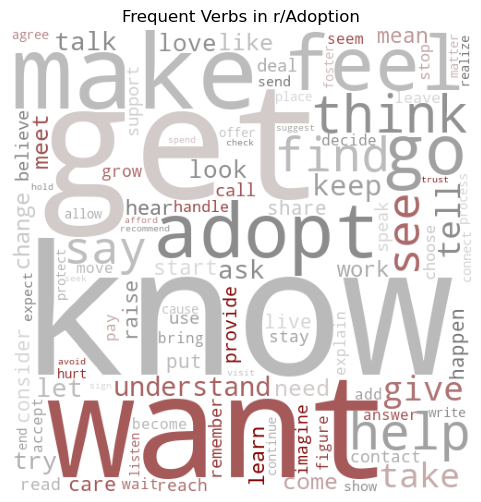

In [ ]:
make_word_cloud(r_adoption_cfdist_POS["NOUN"], max_words=100, 
                title="Frequent Verbs in r/Adoption")

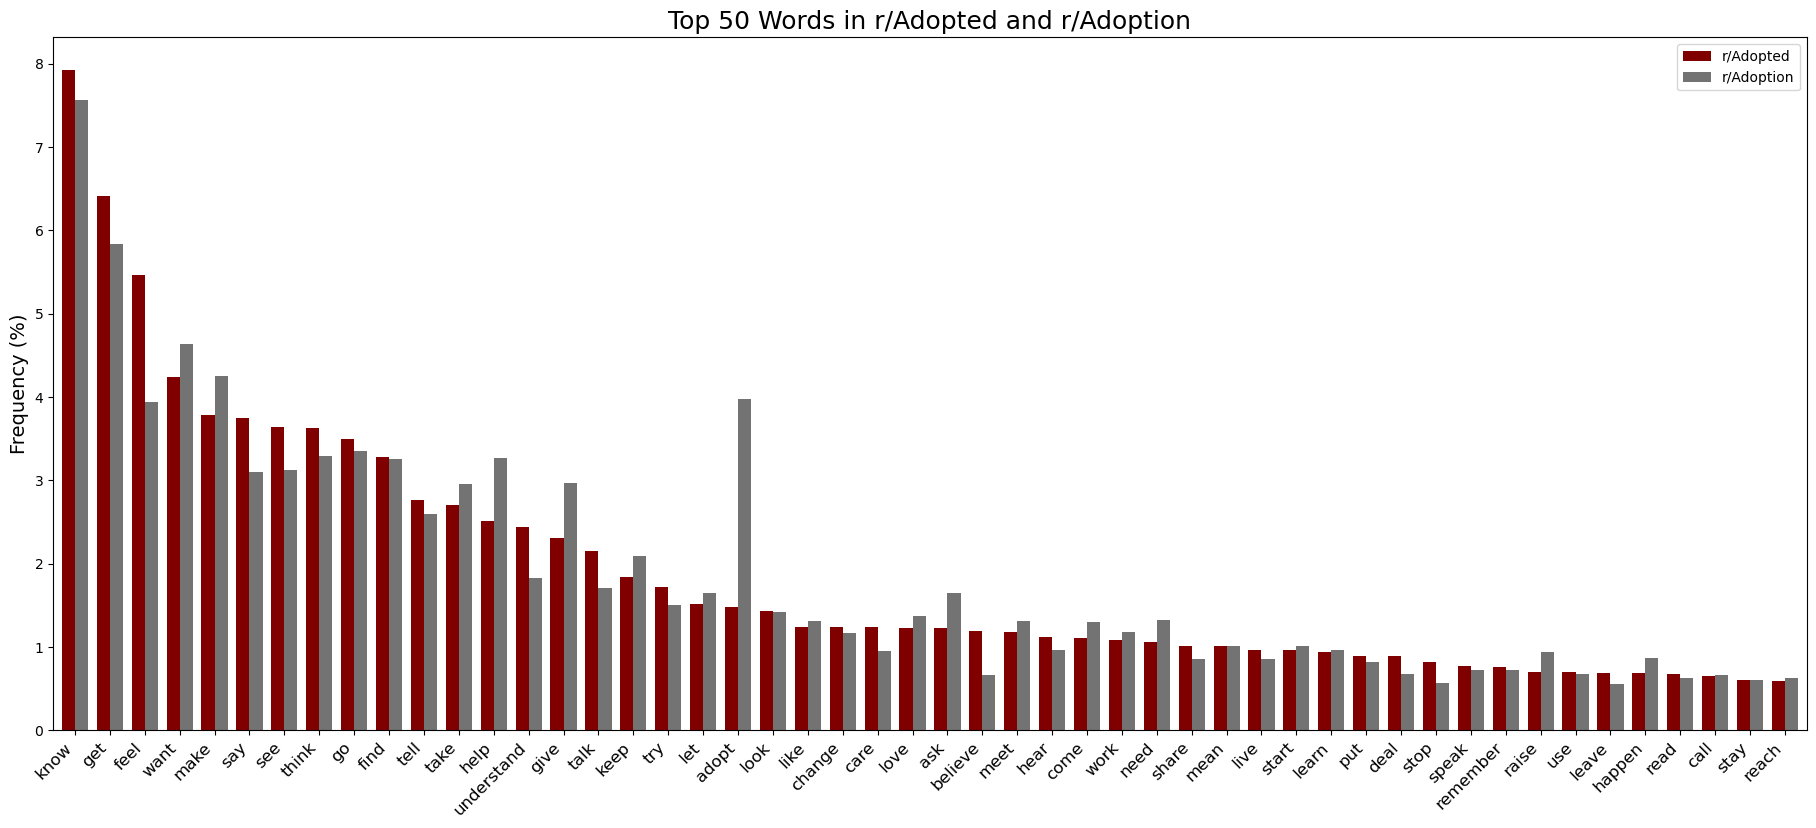

In [ ]:
topical_plot = plot_comp_bars({"r/Adopted":r_adopted_cfdist_POS["VB"], 
                               "r/Adoption":r_adoption_cfdist_POS["VB"]})

In [ ]:
labeled_df = all_df[(all_df.is_adoptee < 2)]
unlabeled_df = all_df[(all_df.is_adoptee == 2)]
labeled_labels = labeled_df.is_adoptee

<Axes: xlabel='is_adoptee'>

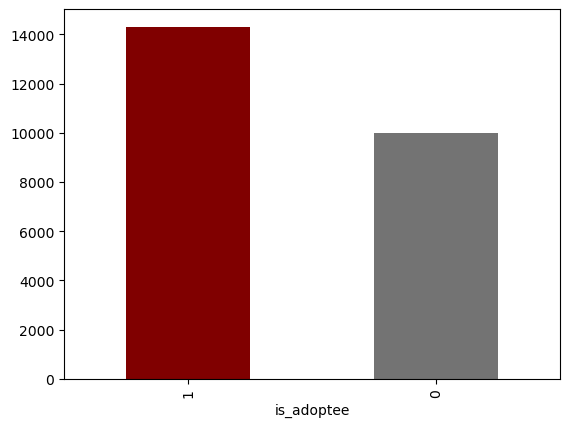

In [ ]:
labeled_df.is_adoptee.value_counts().plot(kind='bar', color=colors[0::3])

We see that among our labeled data, there are more adoptees than non adoptees

Let's see the distribution of n_comments. 

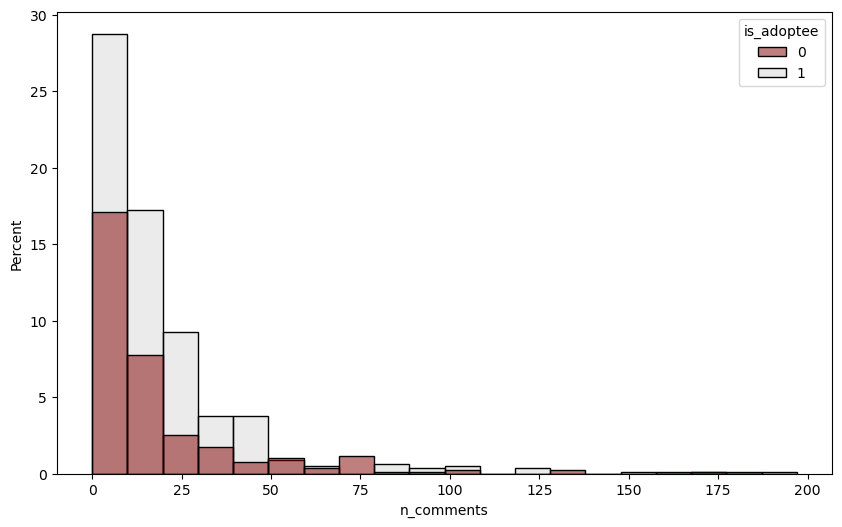

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data = labeled_df, x='n_comments', bins = 20, 
             hue='is_adoptee', stat="percent", palette=colors[:2])
plt.show()

We see that a higher percentage of posts by non adoptees have lower number of comments than those written by adoptees. We see n_comments as a level of engagement. 

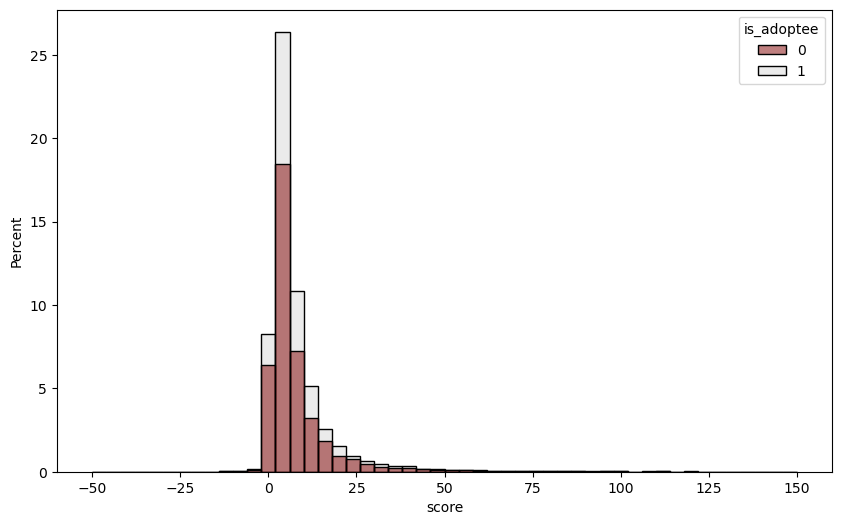

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data = labeled_df, x='score', bins = 50, binrange = (-50, 150),
             hue='is_adoptee', stat="percent", palette=colors[:2])
plt.show()

We also see that most posts hover slightly above zero for their score. We see that non adoptee posts make up the majority of ratings greater than around 10. This is likely due to the sheer number of posts from r/Adoption that make up this data set. So this is not as informative as one might think.

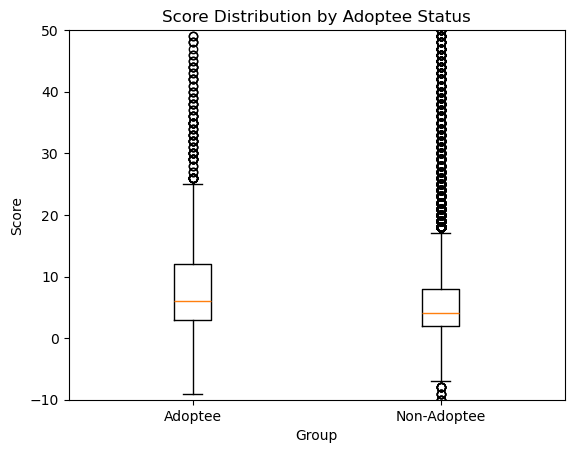

In [ ]:
scores_adopted = labeled_df[labeled_df.subreddit == "r/Adopted"].score.dropna()
scores_non_adoption = labeled_df[labeled_df.subreddit== "r/Adoption"].score.dropna()

# Then, plot these as separate groups in a boxplot
fig, ax = plt.subplots()
ax.boxplot([scores_adopted, scores_non_adoption], labels=['Adoptee', 'Non-Adoptee'])

# Adding labels for clarity
plt.xlabel("Group")
plt.ylabel("Score")
plt.title("Score Distribution by Adoptee Status")
ax.set_ylim(-10, 50)
plt.show()

From the boxplot, we see that there are lots of outliers when it comes to the score. We also see that nonadoptee posts tend to be rated lower by a small margin. Adoptee posts are more variable